In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset (update path for Kaggle environment)
file_path = "/kaggle/input/mergefile/Merged_Disasters(2).csv"
df = pd.read_csv(file_path)

# Clean column names to remove leading/trailing whitespace
df.columns = df.columns.str.strip()

# Ensure target column exists
if "Humanitarian_Class" not in df.columns:
    raise KeyError("Column 'Humanitarian_Class' not found in the dataset. Please check the column names.")

# Stratified split: 80% train, 20% test
train_df, test_df = train_test_split(
    df, test_size=0.20, stratify=df["Humanitarian_Class"], random_state=42
)

# Save splits to CSV in current working directory
train_df.to_csv("/kaggle/working/train_data.csv", index=False)
test_df.to_csv("/kaggle/working/test_data.csv", index=False)

# Structured summary table
split_summary = pd.DataFrame({
    "Train (80%)": train_df["Humanitarian_Class"].value_counts(),
    "Test (20%)": test_df["Humanitarian_Class"].value_counts(),
    "Total": df["Humanitarian_Class"].value_counts()
}).T

# Save summary table
split_summary.to_csv("/kaggle/working/split_summary.csv")

# Print result
print("✅ Data split (80/20) completed and saved as CSV files in /kaggle/working.")


✅ Data split (80/20) completed and saved as CSV files in /kaggle/working.


Loading FastText model...
Generating FastText embeddings...


100%|██████████| 3617/3617 [00:00<00:00, 34947.54it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
204/204 - 6s - 27ms/step - accuracy: 0.5296 - loss: 1.1959 - learning_rate: 0.0010
Epoch 2/20
204/204 - 0s - 2ms/step - accuracy: 0.6832 - loss: 0.8387 - learning_rate: 0.0010
Epoch 3/20
204/204 - 0s - 2ms/step - accuracy: 0.7112 - loss: 0.7632 - learning_rate: 0.0010
Epoch 4/20
204/204 - 0s - 2ms/step - accuracy: 0.7278 - loss: 0.7223 - learning_rate: 0.0010
Epoch 5/20
204/204 - 0s - 2ms/step - accuracy: 0.7448 - loss: 0.6833 - learning_rate: 0.0010
Epoch 6/20
204/204 - 0s - 2ms/step - accuracy: 0.7582 - loss: 0.6484 - learning_rate: 0.0010
Epoch 7/20
204/204 - 0s - 2ms/step - accuracy: 0.7704 - loss: 0.6161 - learning_rate: 0.0010
Epoch 8/20
204/204 - 0s - 2ms/step - accuracy: 0.7740 - loss: 0.5983 - learning_rate: 0.0010
Epoch 9/20
204/204 - 0s - 2ms/step - accuracy: 0.7883 - loss: 0.5680 - learning_rate: 0.0010
Epoch 10/20
204/204 - 0s - 2ms/step - accuracy: 0.7931 - loss: 0.5561 - learning_rate: 0.0010
Epoch 11/20
204/204 - 0s - 2ms/step - accuracy: 0.7992 - loss: 0.537

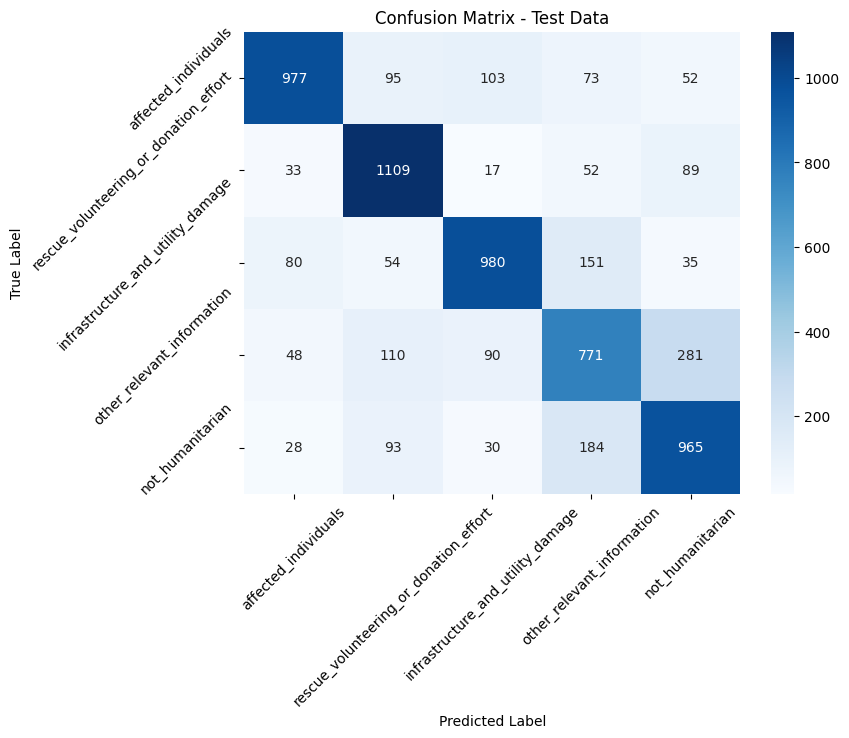

✅ Model saved as 'fasttext_humanitarian_cnn_model.h5'


In [7]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import gensim.downloader as api
from tqdm import tqdm
from collections import Counter

# ========== Load FastText ========== 
print("Loading FastText model...")
fasttext_model = api.load("fasttext-wiki-news-subwords-300")
embedding_dim = 300

# ========== Load Data ========== 
train_df = pd.read_csv("/kaggle/working/train_data.csv")
test_df = pd.read_csv("/kaggle/working/test_data.csv")

# ========== Normalize column names ========== 
for df in [train_df, test_df]:
    df.columns = df.columns.str.strip().str.lower()

# ========== Define label mapping ========== 
label_map = {
    'affected_individuals': 0,
    'rescue_volunteering_or_donation_effort': 1,
    'infrastructure_and_utility_damage': 2,
    'other_relevant_information': 3,
    'not_humanitarian': 4
}

# ========== Preprocess Labels ========== 
for df in [train_df, test_df]:
    df['humanitarian_class'] = df['humanitarian_class'].fillna('not_humanitarian').str.strip().str.lower()

y_train = train_df['humanitarian_class'].map(label_map).astype(int)
y_test = test_df['humanitarian_class'].map(label_map).astype(int)

# ========== Fill missing processed data ========== 
for df in [train_df, test_df]:
    df['processed_data'] = df['processed_data'].fillna("")

# ========== FastText Embedding Function ========== 
def get_avg_embedding(text, model, dim=300):
    words = text.split()
    embeddings = [model[word] for word in words if word in model]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(dim)

# ========== Generate FastText Vectors ========== 
print("Generating FastText embeddings...")
X_train_embed = np.vstack([get_avg_embedding(text, fasttext_model, embedding_dim) for text in tqdm(train_df['processed_data'])])
X_test_embed = np.vstack([get_avg_embedding(text, fasttext_model, embedding_dim) for text in tqdm(test_df['processed_data'])])

# ========== Handcrafted Features ========== 
for df in [train_df, test_df]:
    df['tweet_length'] = df['processed_data'].apply(len)
    df['num_hashtags'] = df['processed_data'].apply(lambda x: x.count("#"))
    df['num_mentions'] = df['processed_data'].apply(lambda x: x.count("@"))

scaler = StandardScaler()
X_train_features = scaler.fit_transform(train_df[['tweet_length', 'num_hashtags', 'num_mentions']])
X_test_features = scaler.transform(test_df[['tweet_length', 'num_hashtags', 'num_mentions']])

# ========== Combine FastText + Numerical Features ========== 
X_train_combined = np.hstack((X_train_embed, X_train_features))
X_test_combined = np.hstack((X_test_embed, X_test_features))

# ========== Apply SMOTE ========== 
# SMOTE for training
max_class_samples = max(Counter(y_train).values())
sampling_strategy = {label: max_class_samples for label in np.unique(y_train)}
smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=3, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_combined, y_train)

# SMOTE for testing
max_class_test = max(Counter(y_test).values())
sampling_strategy_test = {label: max_class_test for label in np.unique(y_test)}
X_test_resampled, y_test_resampled = SMOTE(sampling_strategy=sampling_strategy_test, k_neighbors=3, random_state=42).fit_resample(X_test_combined, y_test)

# ========== CNN Model Definition ========== 
def create_cnn_model(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ========== Train CNN Model ========== 
model = create_cnn_model(X_train_resampled.shape[1], len(label_map))

callbacks = [
    EarlyStopping(monitor='loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=1e-6)
]

history = model.fit(X_train_resampled, y_train_resampled, epochs=20, batch_size=128, callbacks=callbacks, verbose=2)

# ========== Evaluate on SMOTE-applied Test Set ========== 
test_loss, test_acc = model.evaluate(X_test_resampled, y_test_resampled, verbose=0)
print(f"✅ Test Accuracy: {test_acc:.4f}")

# ========== Predictions and Reports ========== 
y_pred_test = model.predict(X_test_resampled)
y_pred_test = np.argmax(y_pred_test, axis=1)

# Classification Report
report_test = classification_report(y_test_resampled, y_pred_test, target_names=label_map.keys())
print("\n📋 Classification Report (Test):\n", report_test)

# Confusion Matrix
cm_test = confusion_matrix(y_test_resampled, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_map.keys(),
            yticklabels=label_map.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Data")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# ========== Save the Model ========== 
model.save("fasttext_humanitarian_cnn_model.h5")
print("✅ Model saved as 'fasttext_humanitarian_cnn_model.h5'")
